In [ ]:
# results obtained from E1
degree = 3
compression_rate = 0.3

In [ ]:
from utils.data import load_ucr_data_short, load_ucr_dataset

# load data
#data = load_ucr_data_short()
data = load_ucr_dataset(48)
print("number of time series:", len(data.index))

In [ ]:
%%time
from utils.plot import plot_inverse_DFT, plot_splines
from utils.data import remove_outliers
from utils.compression import round_to_nearest_ratio
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count, calculate_max_dist
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_PAA, fit_DFT, calculate_inverse_DFT
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

results = []
counter = 0
for index, row in data.iterrows():

    ts_with_outliers = row['data']
    ts_without_outliers = remove_outliers(ts_with_outliers)
    ts = [(0, ts_with_outliers),  # (num_outliers_removed, ts)
          (len(ts_with_outliers) - len(ts_without_outliers), ts_without_outliers)]  #(num_outliers_removed, ts_lof)

    print(row['dataset'], "no.", row['num'], round(counter / len(data.index) * 100, 1), "% processed")
    counter += 1

    for num_outliers_removed, time_series in ts:

        num_coeffs = generate_coeff_counts(len(time_series), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        # L8 (degree = 3)
        max_dist, result = fit_max_spline(time_series, knots, degree)

        if max_dist is not None and result is not None:
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(time_series),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': 'L8',
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })

        # L8-L1 (degree = 3)
        result = fit_max_l1_spline(time_series, knots, degree, eps=0.000001)[1]

        if max_dist is not None and result is not None:
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
            max_dist = calculate_max_dist(knots, result, degree, time_series)[0]

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(time_series),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': 'L8 and L1',
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })

        # LSQ (degree = 3)
        try:
            result = scipy.interpolate.make_lsq_spline([x[0] for x in time_series], [x[1] for x in time_series],
                                                       knots, k=degree).c

            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
            max_dist = calculate_max_dist(knots, result, degree, time_series)[0]

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(time_series),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': 'LSQ',
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })

        except:
            print("LSQ problem")

        # PAA (degree = 0)

        max_dist, result = fit_max_spline(time_series, knots, 0)

        if max_dist is not None and result is not None:
            fitted_spline = [evaluate_spline(knots, result, 0, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(time_series),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': 'PAA',
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })

        # PLA (degree = 1)

        max_dist, result = fit_max_spline(time_series, knots, 1)

        if max_dist is not None and result is not None:
            fitted_spline = [evaluate_spline(knots, result, 1, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(time_series),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': 'PLA',
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })
            
        plot_splines(plt,knots,3,time_series)

        # DFT
        result = fit_DFT(time_series,num_coeffs)
        fitted_curve = calculate_inverse_DFT(len(time_series), num_coeffs, result)
        max_dist = np.max(np.abs(fitted_curve - [tup[1] for tup in time_series]))
        mse = mean_squared_error(fitted_curve, [x[1] for x in time_series])
        mae = mean_absolute_error(fitted_curve, [x[1] for x in time_series])
        
        plot_inverse_DFT(fitted_curve, time_series,num_coeffs)

        results.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(time_series),
            'num_outliers_removed': num_outliers_removed,
            'num_coeffs': num_coeffs,
            'method': 'DFT',
            'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae
        })

        #plot_splines(plt, knots, degree, time_series)
        #plt.show()


In [13]:
e2_results = pd.DataFrame(results)
mean_values = e2_results.groupby('method').agg({'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values

,method,max_dist,MSE,MAE
0,DFT,0.733835,0.022471,0.078962
1,L8,0.052448,0.001811,0.035436
2,L8 and L1,0.052449,0.000851,0.018011
3,LSQ,0.069565,0.000427,0.011766
4,PAA,0.262012,0.064725,0.218909
5,PLA,0.068805,0.003657,0.051116


In [20]:
import pandas as pd

df_no_outliers = e2_results[e2_results['num_outliers_removed'] == 0]

df_with_outliers = e2_results[e2_results['num_outliers_removed'] > 0]

mean_values_no_outliers = df_no_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_no_outliers.rename(columns={'max_dist': 'max_dist w/o o.', 'MSE': 'MSE w/o o.', 'MAE': 'MAE w/o o.'},
                               inplace=True)

mean_values_with_outliers = df_with_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_with_outliers.rename(columns={'max_dist': 'max_dist', 'MSE': 'MSE', 'MAE': 'MAE'}, inplace=True)

mean_values_combined = pd.merge(mean_values_with_outliers, mean_values_no_outliers, on='method', how='outer')

mean_values_combined


,method,max_dist,MSE,MAE,max_dist w/o o.,MSE w/o o.,MAE w/o o.
0,DFT,0.878677,0.039515,0.130105,0.625204,0.009688,0.040604
1,L8,0.052429,0.001887,0.035166,0.052466,0.001734,0.035707
2,L8 and L1,0.052430,0.000829,0.016969,0.052467,0.000873,0.019052
3,LSQ,0.057976,0.000371,0.010494,0.078258,0.000469,0.012721
4,PAA,0.247819,0.058728,0.208622,0.276204,0.070721,0.229197
5,PLA,0.074825,0.004429,0.055520,0.062786,0.002884,0.046712


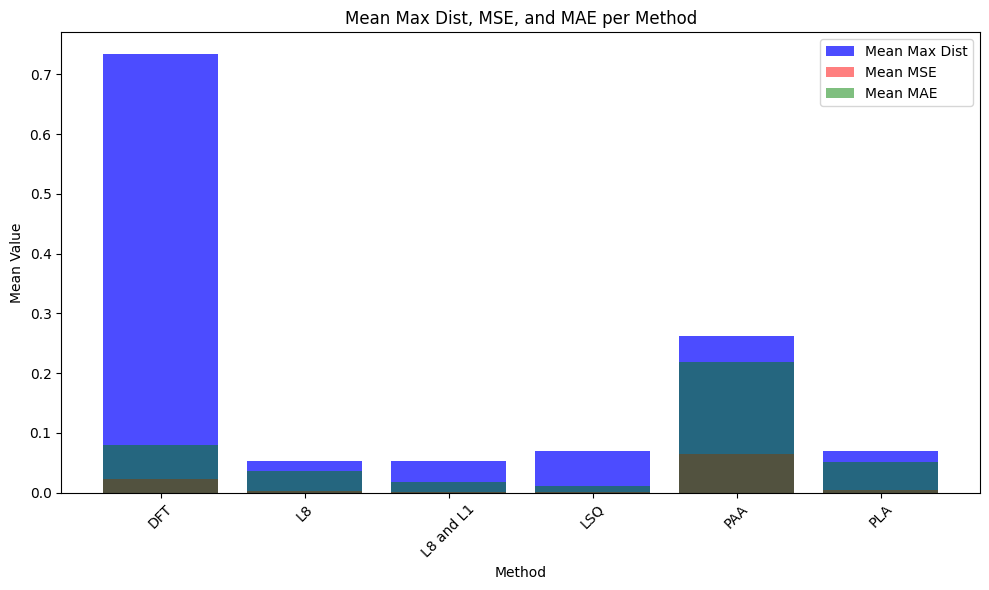

In [21]:
import matplotlib.pyplot as plt

# Plot mean values
plt.figure(figsize=(10, 6))
plt.bar(mean_values['method'], mean_values['max_dist'], color='b', alpha=0.7, label='Mean Max Dist')
plt.bar(mean_values['method'], mean_values['MSE'], color='r', alpha=0.5, label='Mean MSE')
plt.bar(mean_values['method'], mean_values['MAE'], color='g', alpha=0.5, label='Mean MAE')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Mean Max Dist, MSE, and MAE per Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


GestureMidAirD3 no. 0, 0.5% processed


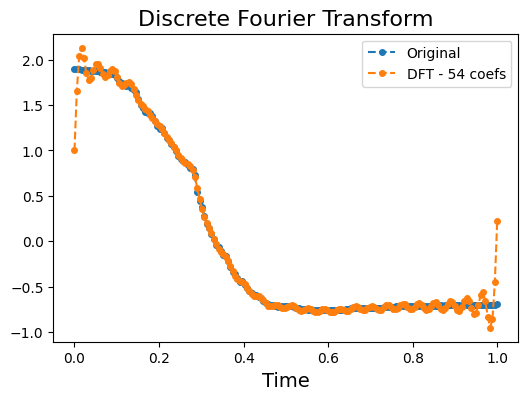

LSQ problem


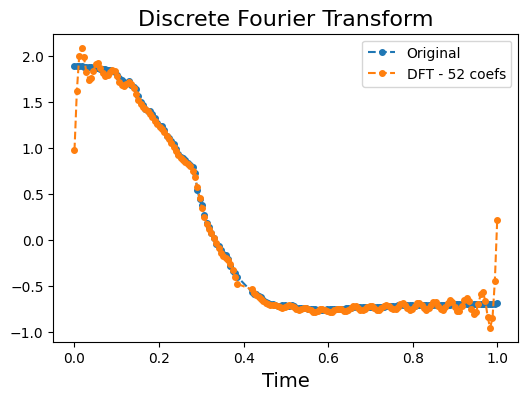

GestureMidAirD3 no. 1, 1.0% processed
LSQ problem


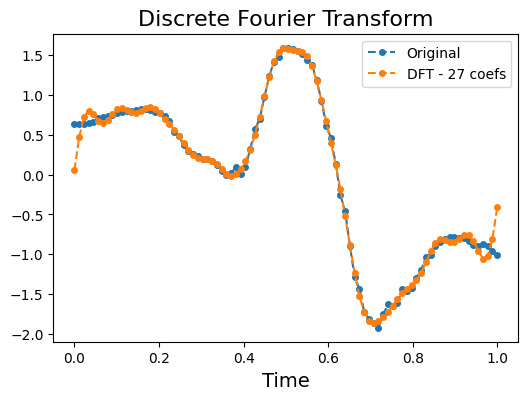

LSQ problem


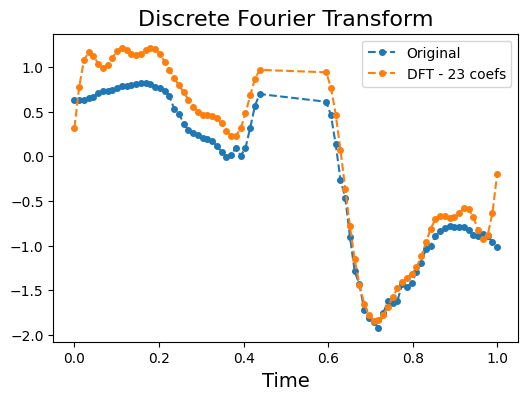

GestureMidAirD3 no. 2, 1.4% processed
LSQ problem


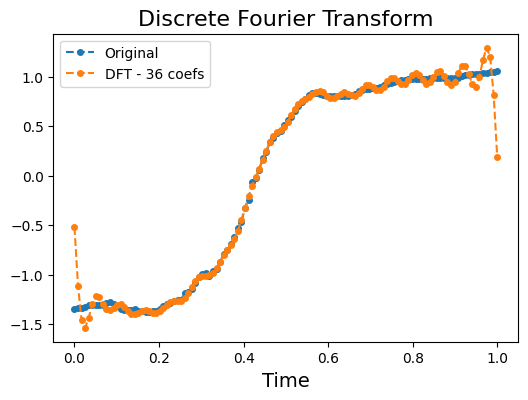

LSQ problem


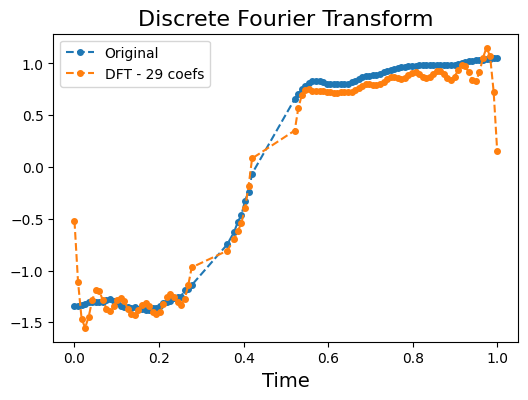

GestureMidAirD3 no. 3, 1.9% processed
LSQ problem


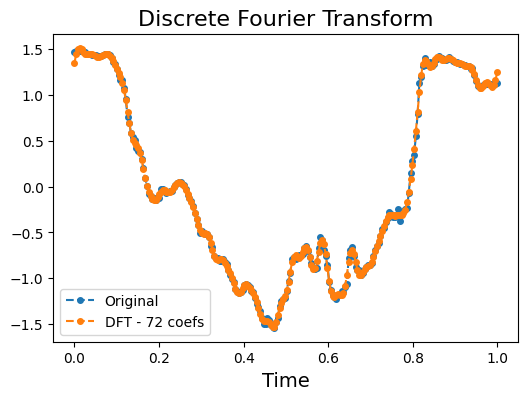

LSQ problem


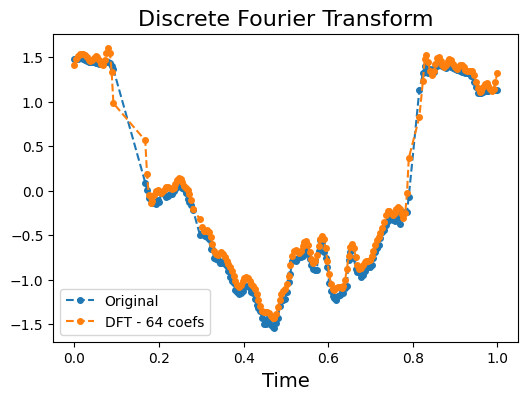

GestureMidAirD3 no. 4, 2.4% processed
LSQ problem


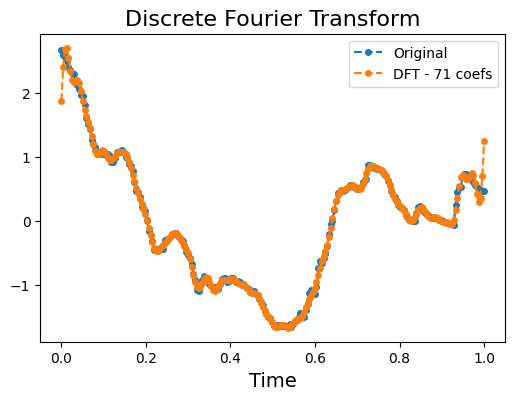

LSQ problem


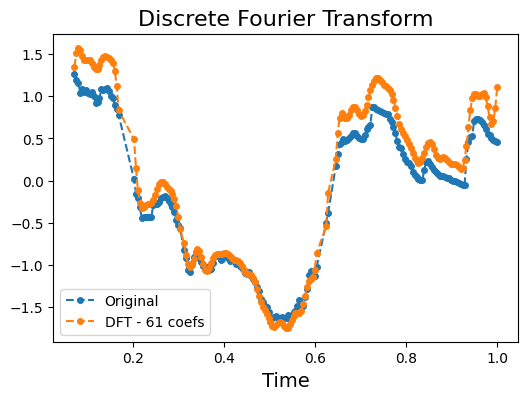

GestureMidAirD3 no. 5, 2.9% processed
LSQ problem


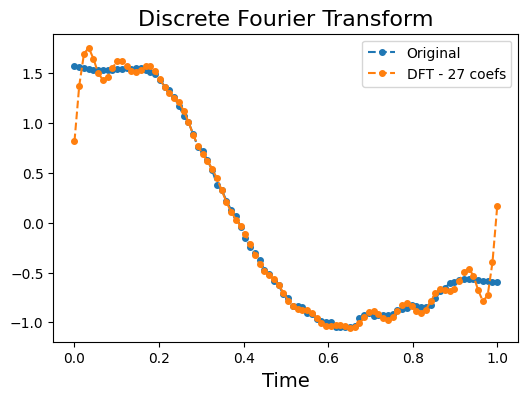

LSQ problem


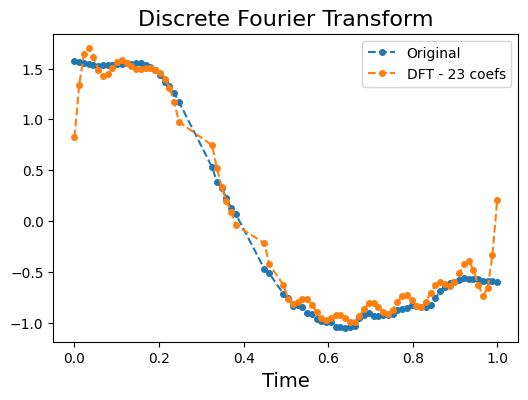

GestureMidAirD3 no. 6, 3.4% processed
LSQ problem


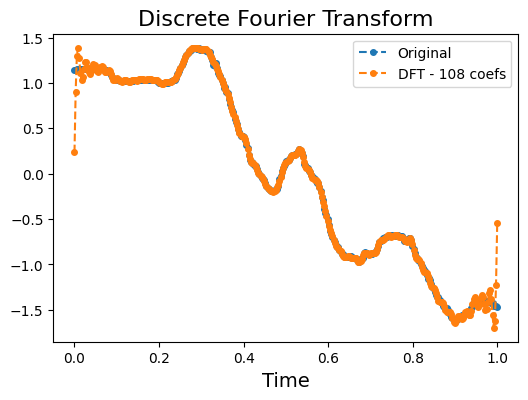

LSQ problem


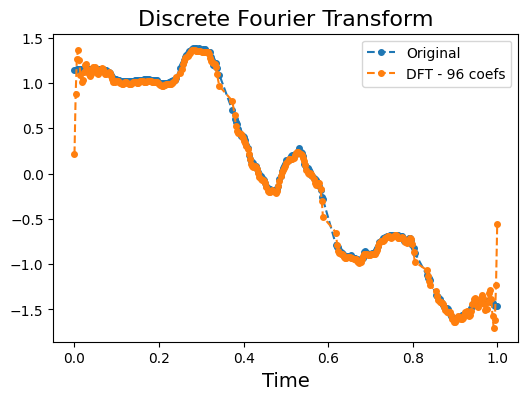

GestureMidAirD3 no. 7, 3.8% processed
LSQ problem


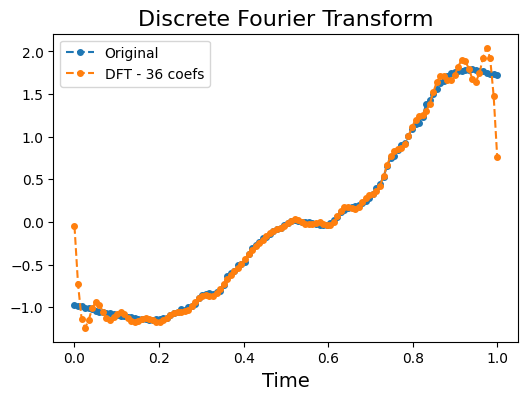

LSQ problem


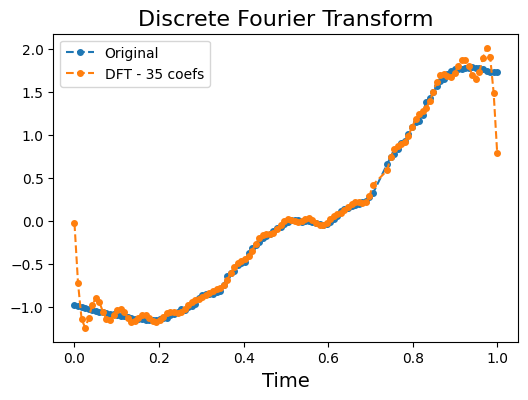

GestureMidAirD3 no. 8, 4.3% processed
LSQ problem


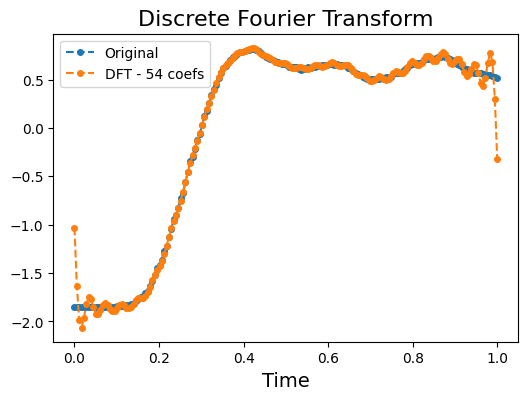

LSQ problem


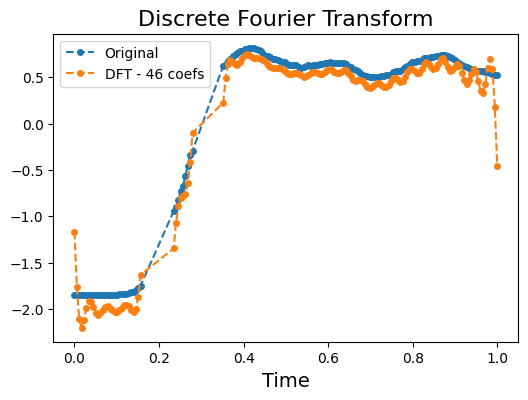

GestureMidAirD3 no. 9, 4.8% processed
LSQ problem


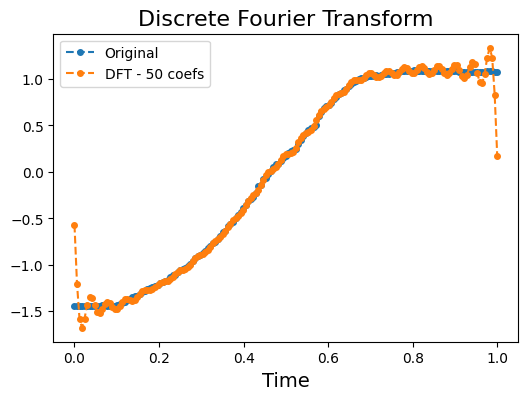

LSQ problem


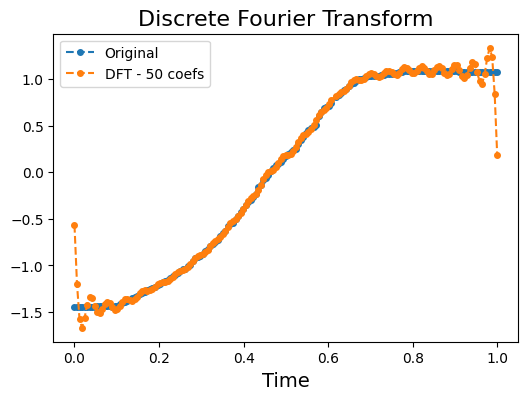

GestureMidAirD3 no. 10, 5.3% processed
LSQ problem


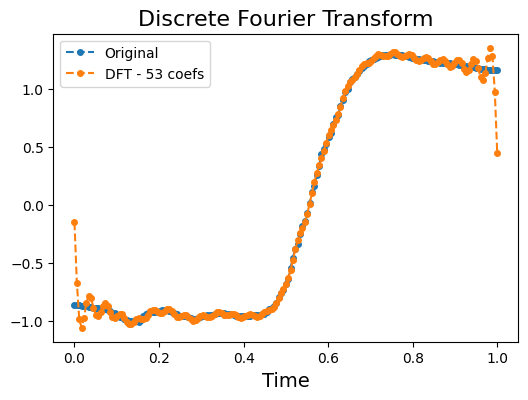

LSQ problem


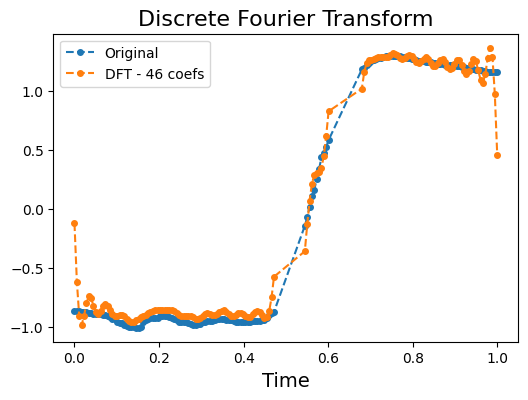

GestureMidAirD3 no. 11, 5.8% processed
LSQ problem


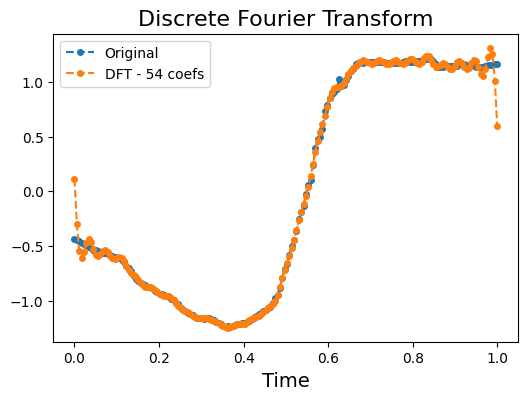

LSQ problem


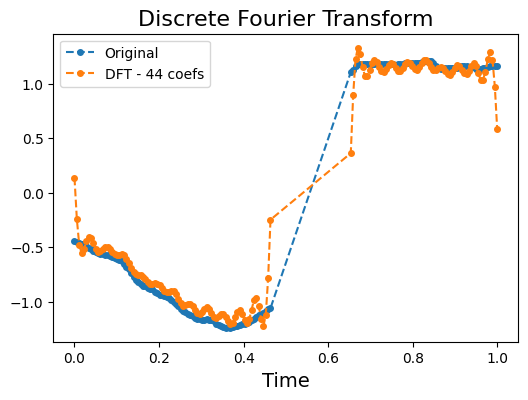

GestureMidAirD3 no. 12, 6.2% processed
LSQ problem


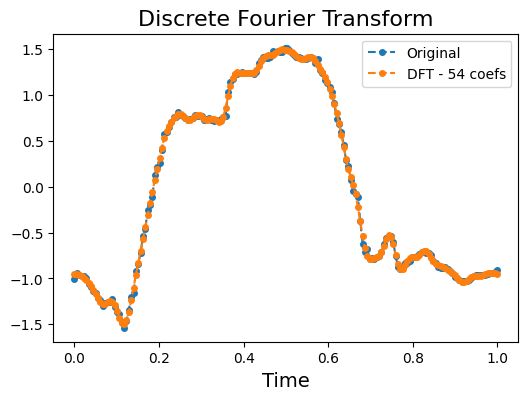

LSQ problem


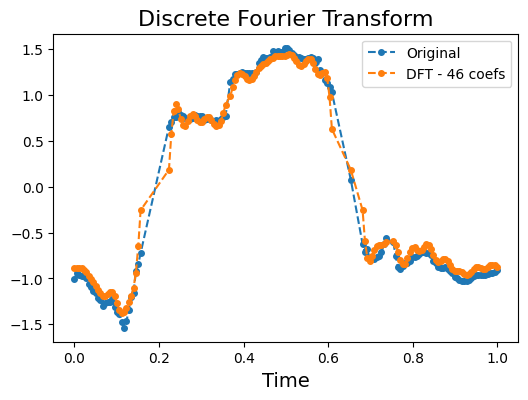

GestureMidAirD3 no. 13, 6.7% processed
LSQ problem


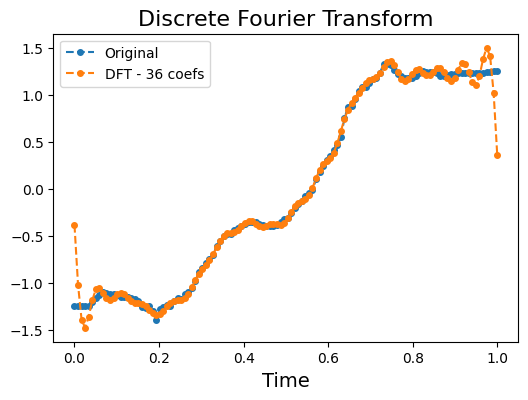

LSQ problem


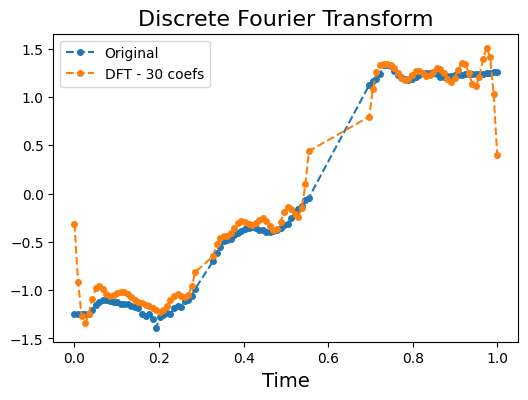

GestureMidAirD3 no. 14, 7.2% processed
LSQ problem


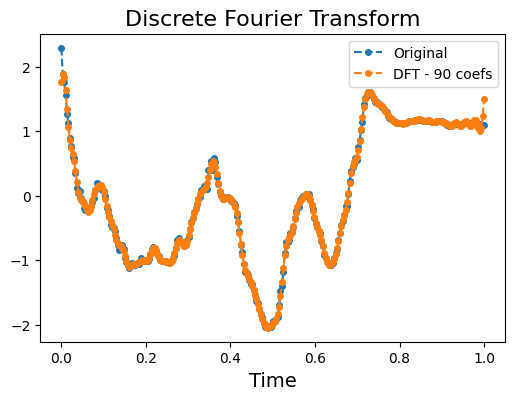

LSQ problem


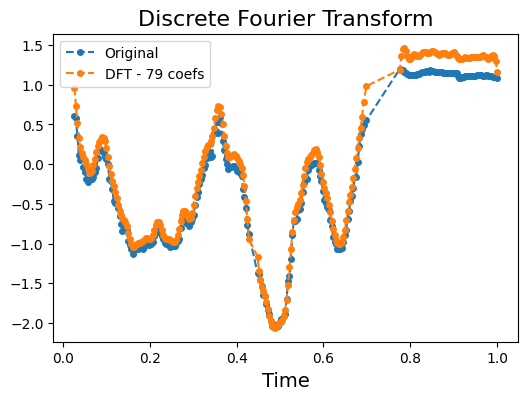

GestureMidAirD3 no. 15, 7.7% processed
LSQ problem


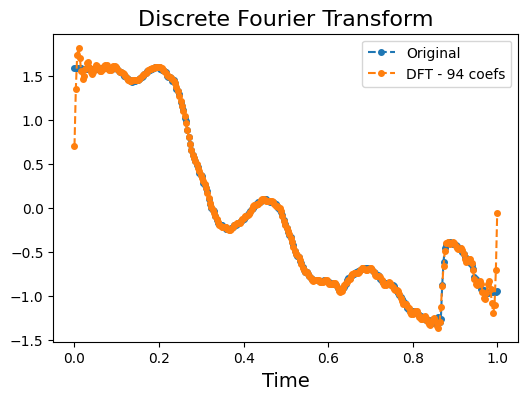

LSQ problem


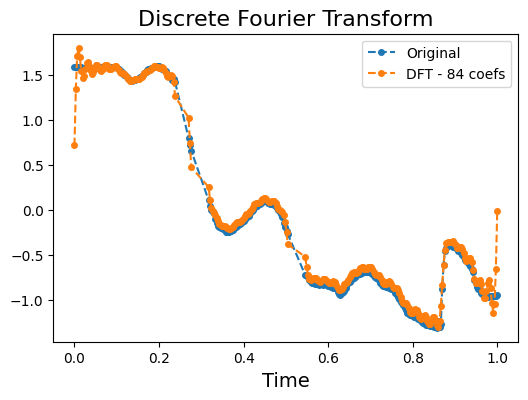

GestureMidAirD3 no. 16, 8.2% processed
LSQ problem


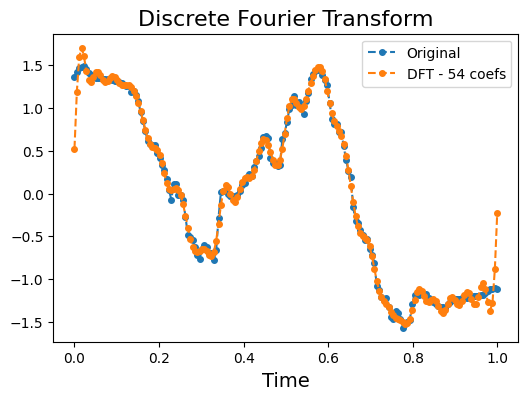

LSQ problem


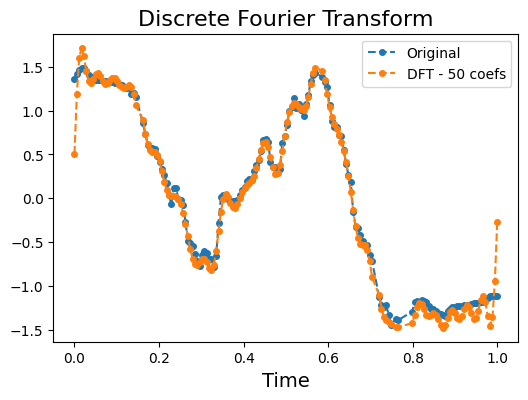

GestureMidAirD3 no. 17, 8.7% processed
LSQ problem


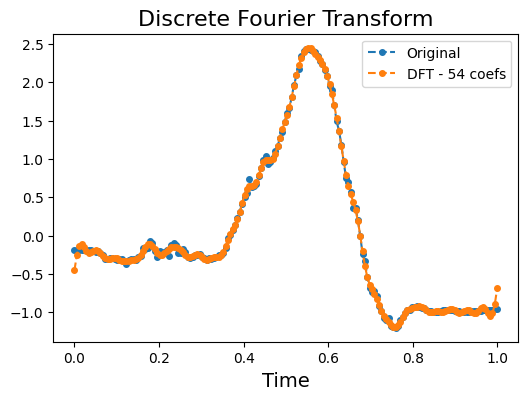

LSQ problem


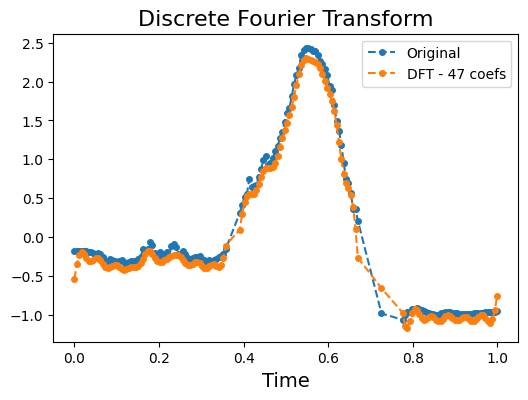

GestureMidAirD3 no. 18, 9.1% processed
LSQ problem


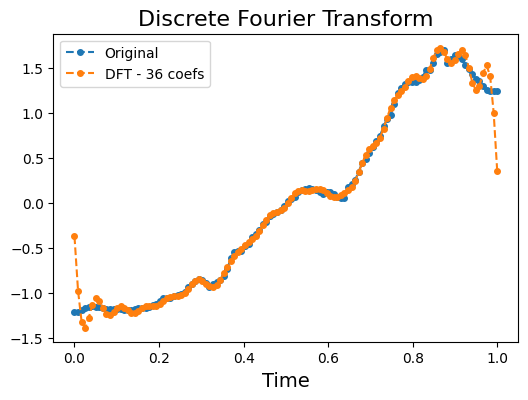

LSQ problem


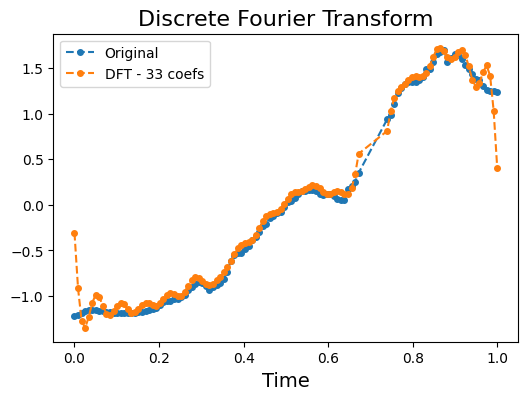

GestureMidAirD3 no. 19, 9.6% processed
LSQ problem


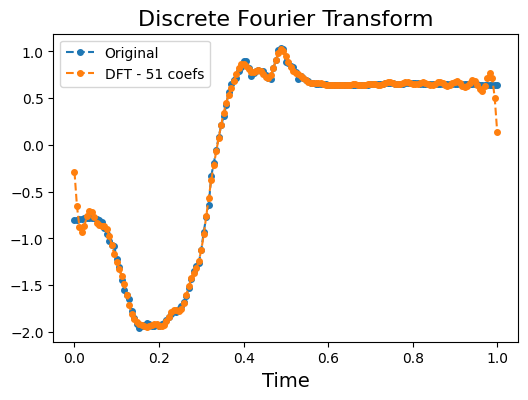

LSQ problem


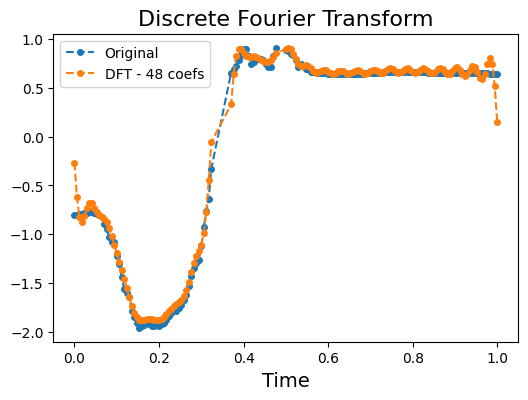

GestureMidAirD3 no. 20, 10.1% processed
LSQ problem


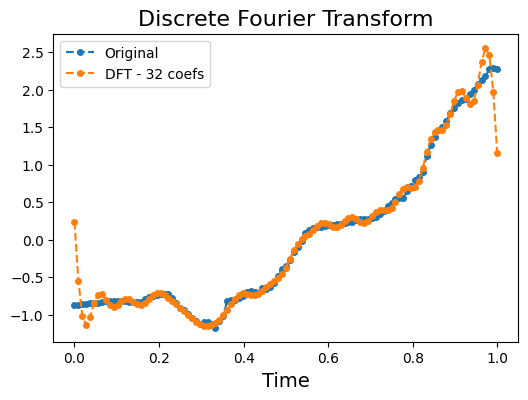

LSQ problem


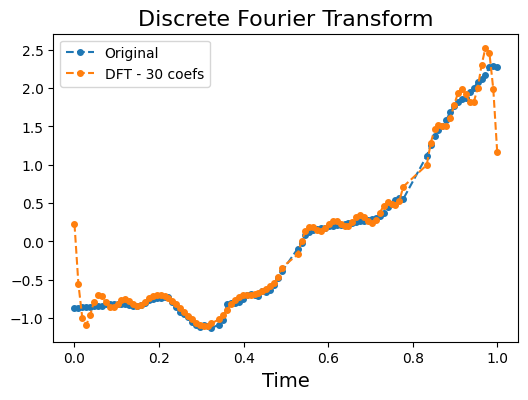

GestureMidAirD3 no. 21, 10.6% processed
LSQ problem


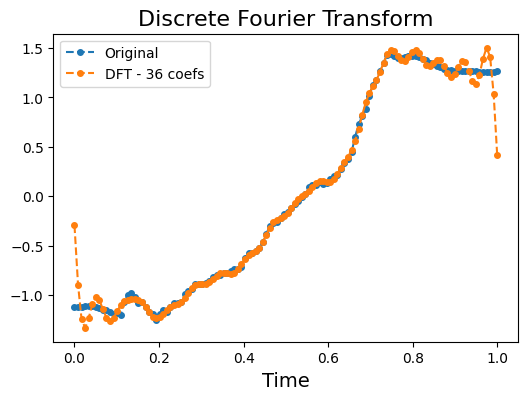

LSQ problem


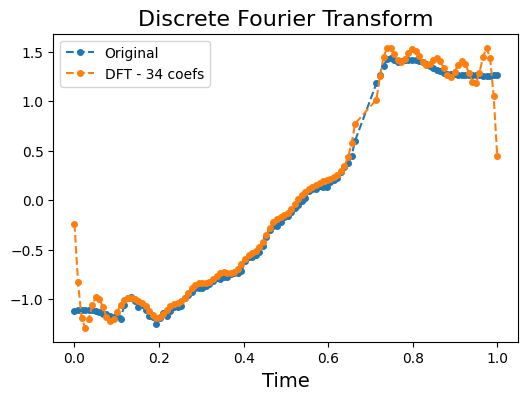

GestureMidAirD3 no. 22, 11.1% processed
LSQ problem


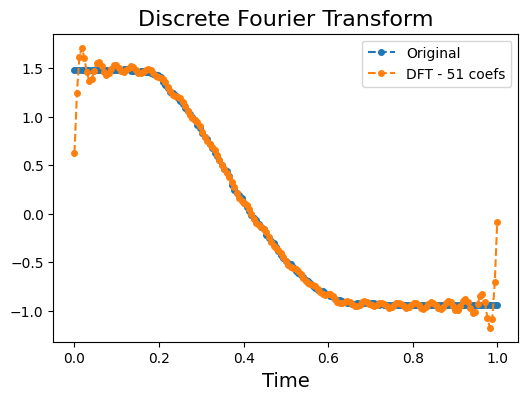

LSQ problem


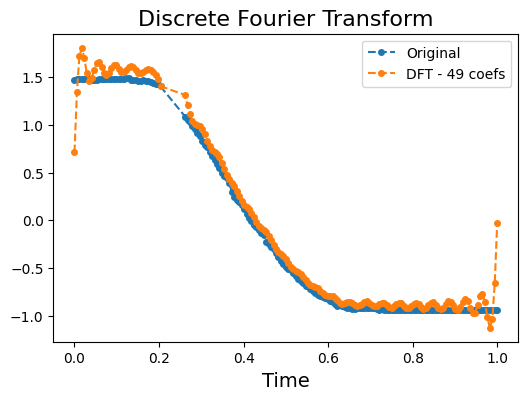

GestureMidAirD3 no. 23, 11.5% processed
LSQ problem


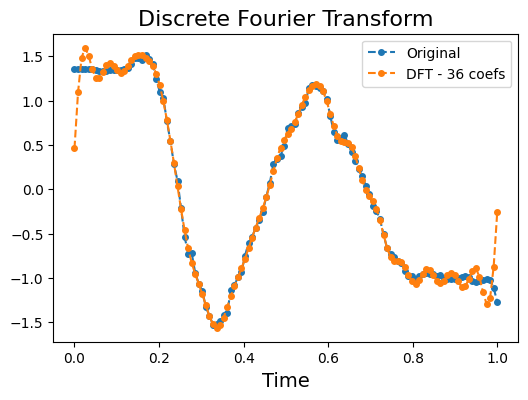

LSQ problem


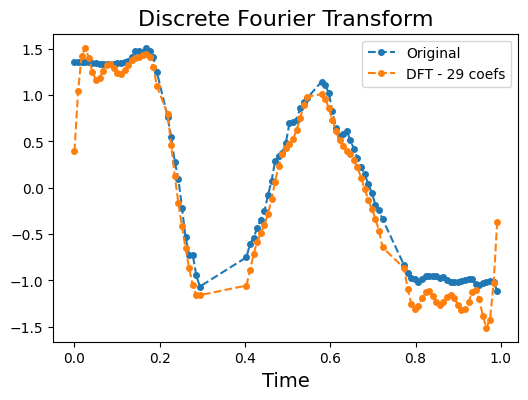

GestureMidAirD3 no. 24, 12.0% processed
LSQ problem


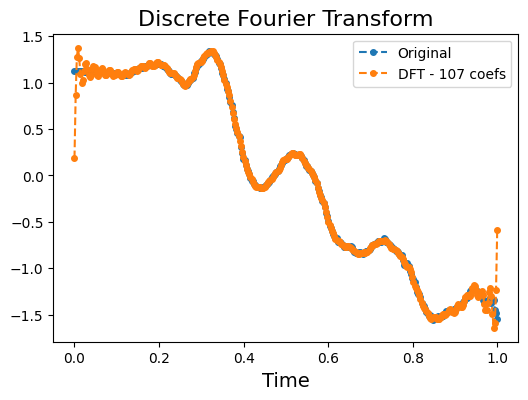

LSQ problem


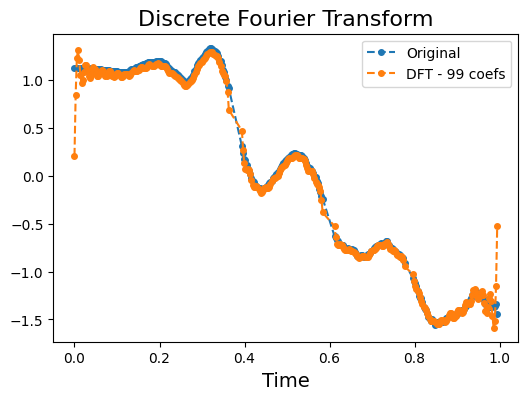

GestureMidAirD3 no. 25, 12.5% processed
LSQ problem


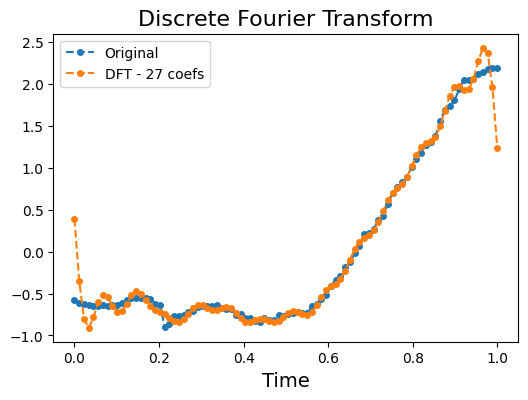

LSQ problem


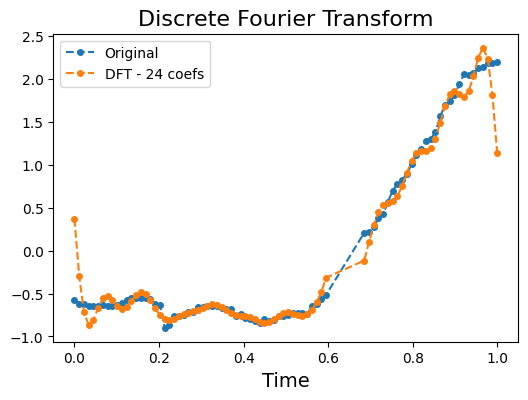

GestureMidAirD3 no. 26, 13.0% processed
LSQ problem


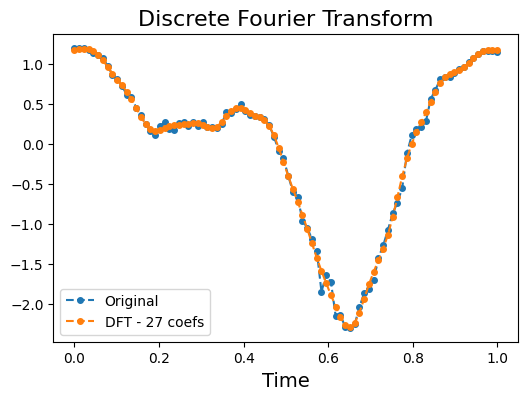

LSQ problem


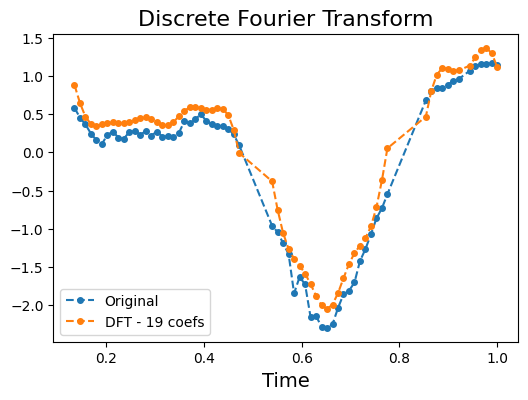

GestureMidAirD3 no. 27, 13.5% processed
LSQ problem


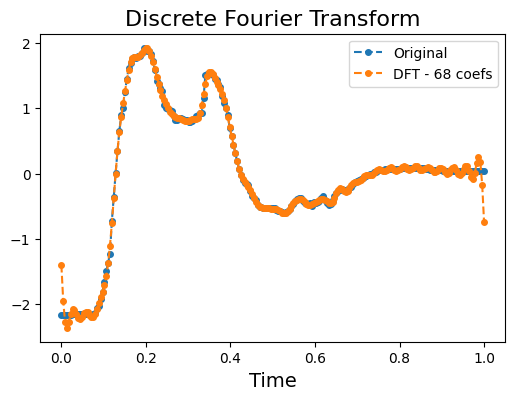

LSQ problem


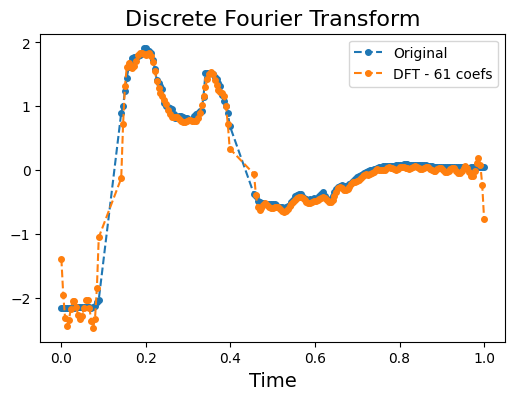

GestureMidAirD3 no. 28, 13.9% processed
LSQ problem


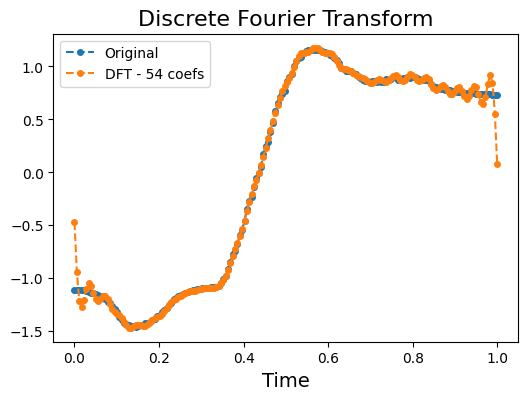

LSQ problem


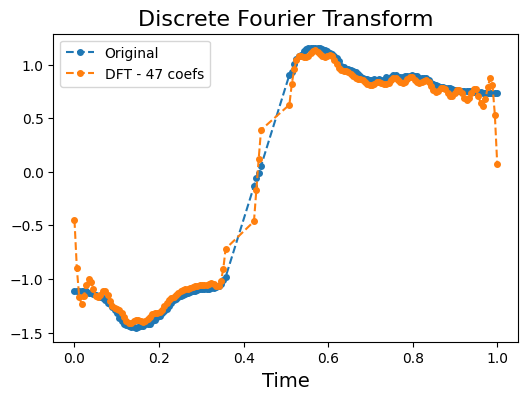

GestureMidAirD3 no. 29, 14.4% processed
LSQ problem


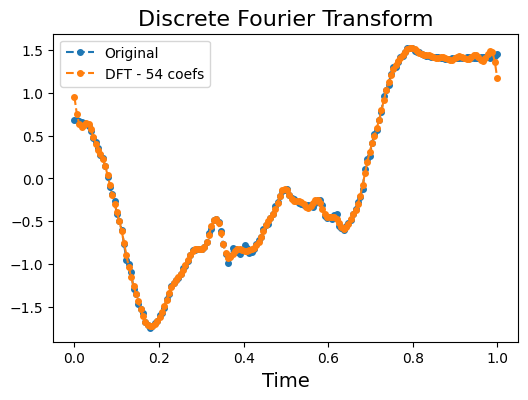

LSQ problem


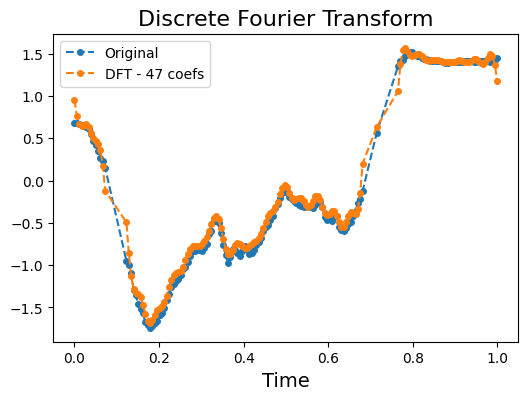

GestureMidAirD3 no. 30, 14.9% processed
LSQ problem


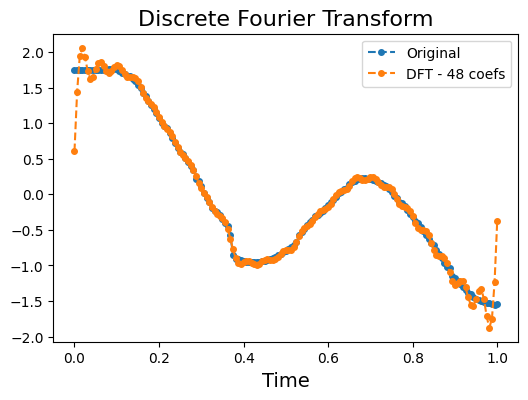

LSQ problem


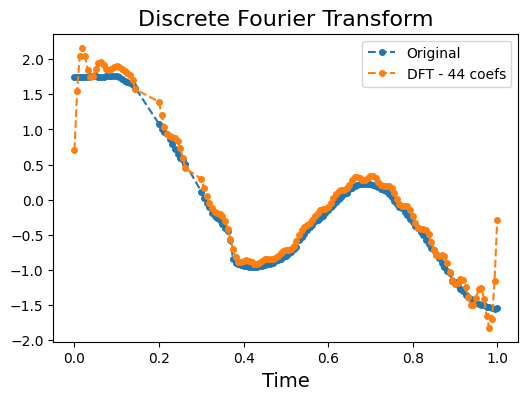

GestureMidAirD3 no. 31, 15.4% processed
LSQ problem


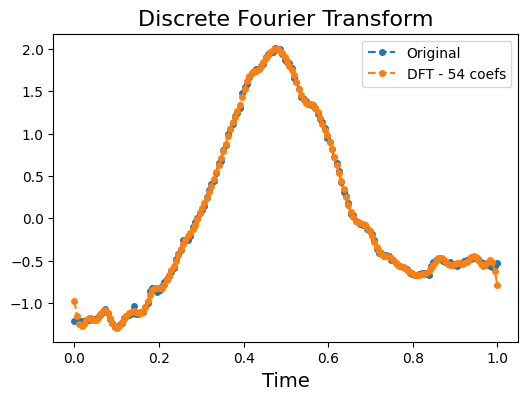

LSQ problem


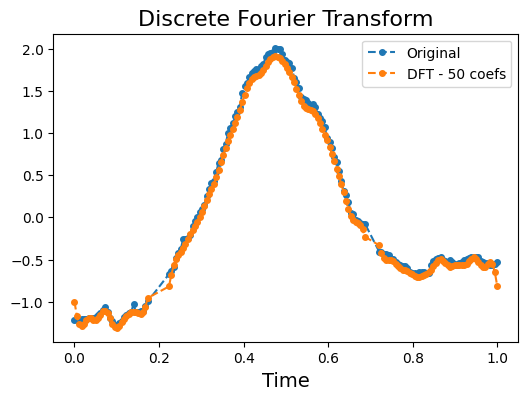

GestureMidAirD3 no. 32, 15.9% processed
LSQ problem


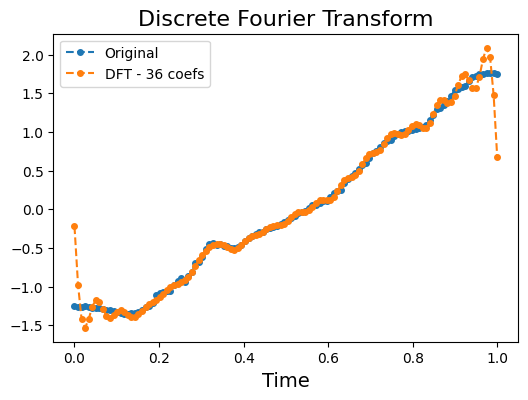

LSQ problem


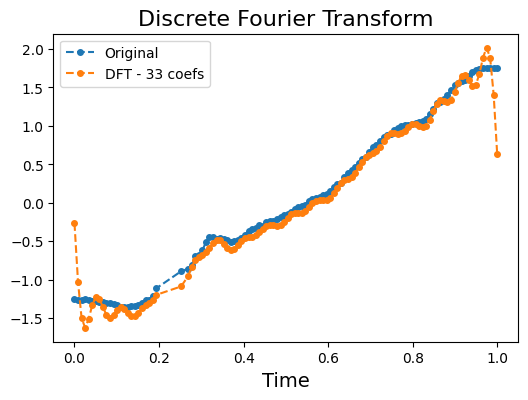

GestureMidAirD3 no. 33, 16.3% processed
LSQ problem


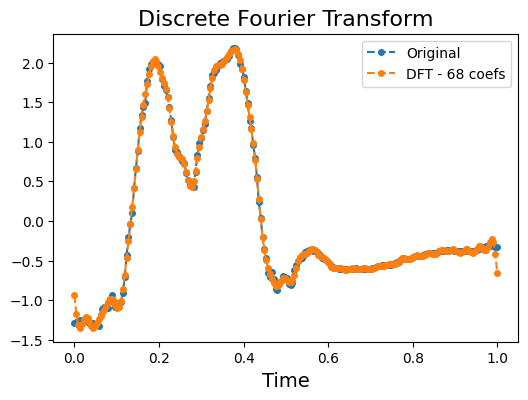

LSQ problem


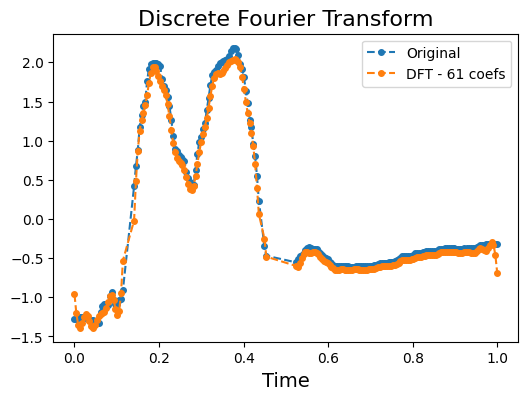

GestureMidAirD3 no. 34, 16.8% processed
LSQ problem


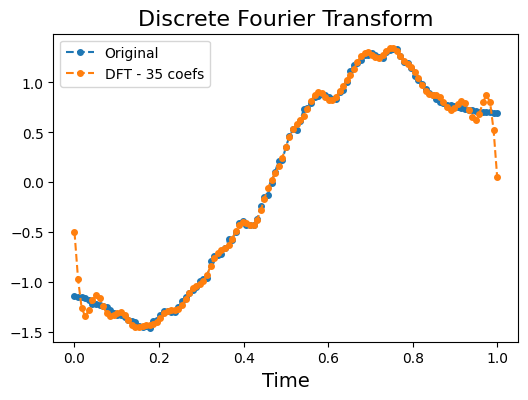

LSQ problem


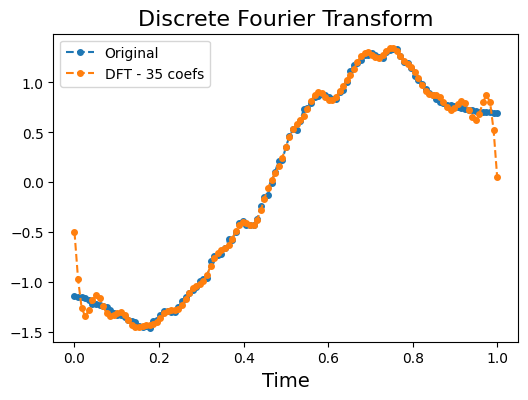

GestureMidAirD3 no. 35, 17.3% processed
LSQ problem


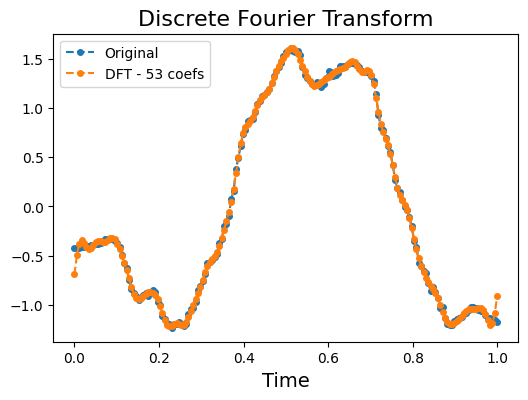

LSQ problem


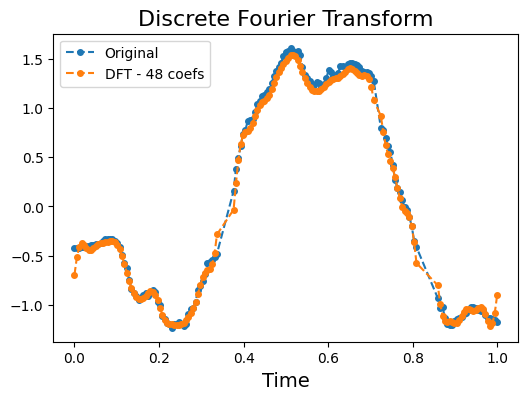

GestureMidAirD3 no. 36, 17.8% processed
LSQ problem


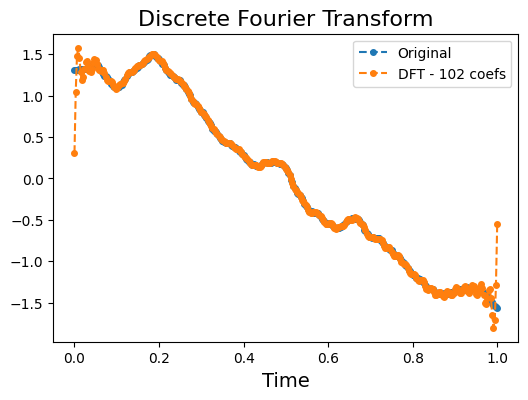

LSQ problem


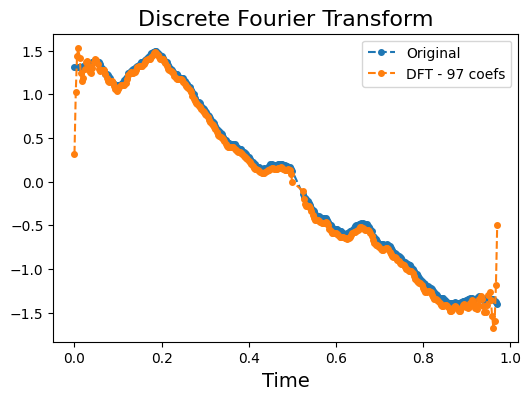

GestureMidAirD3 no. 37, 18.3% processed
LSQ problem


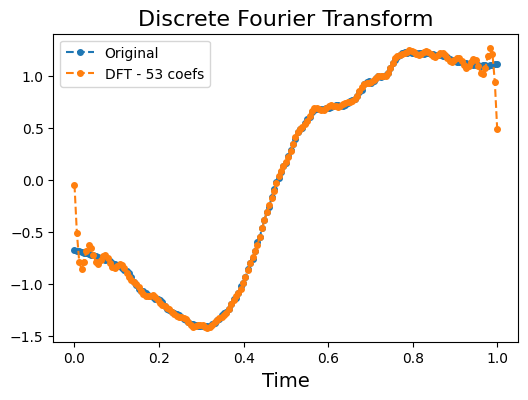

LSQ problem


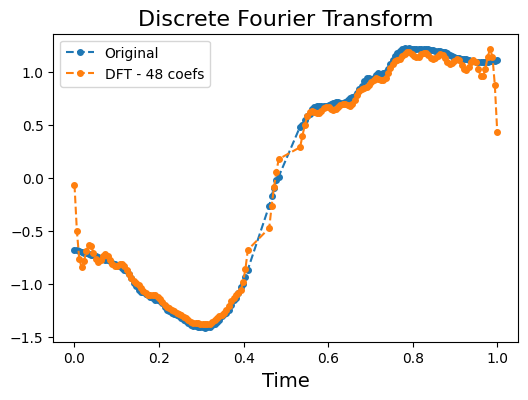

GestureMidAirD3 no. 38, 18.8% processed
LSQ problem


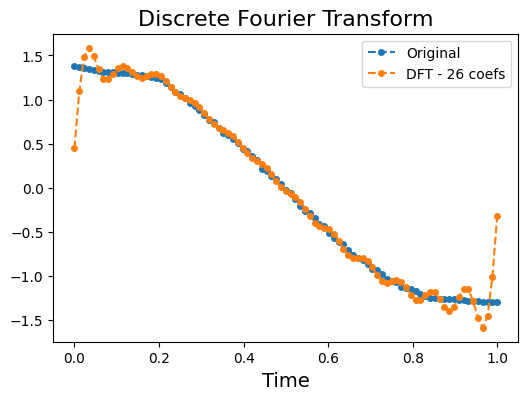

LSQ problem


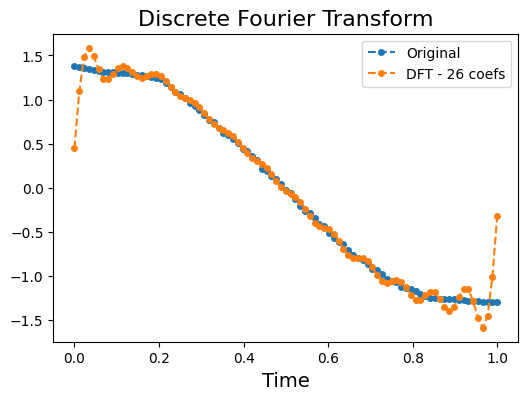

GestureMidAirD3 no. 39, 19.2% processed
LSQ problem


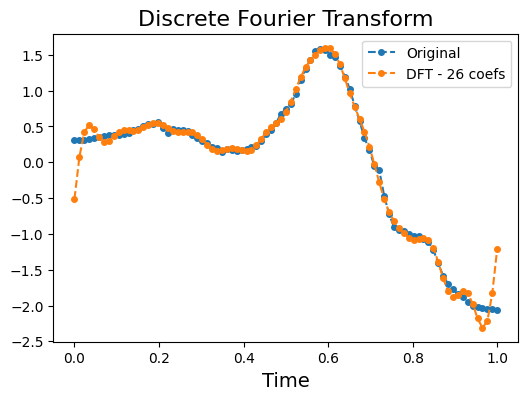

LSQ problem


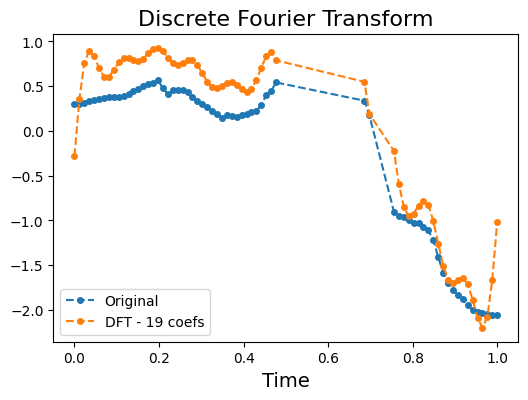

GestureMidAirD3 no. 40, 19.7% processed
LSQ problem


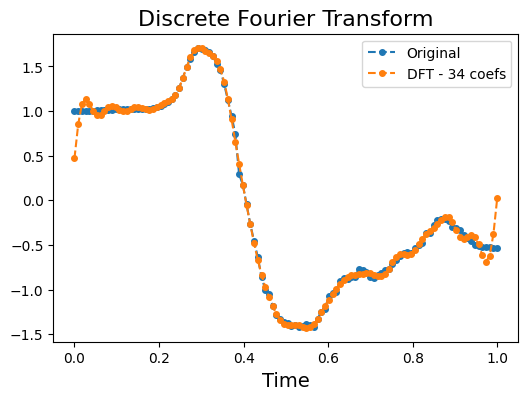

LSQ problem


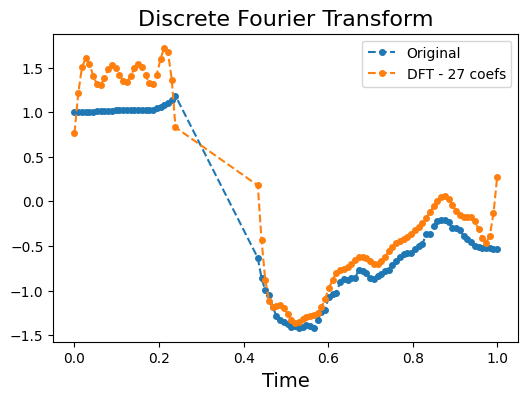

GestureMidAirD3 no. 41, 20.2% processed
LSQ problem


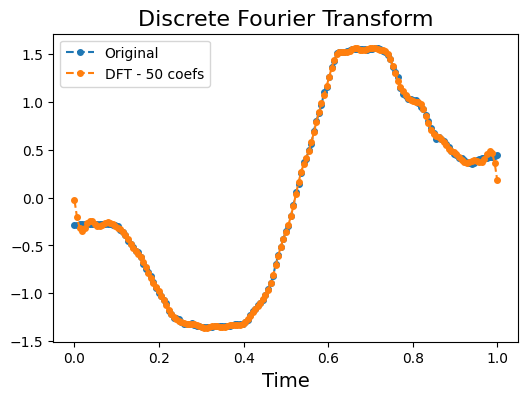

LSQ problem


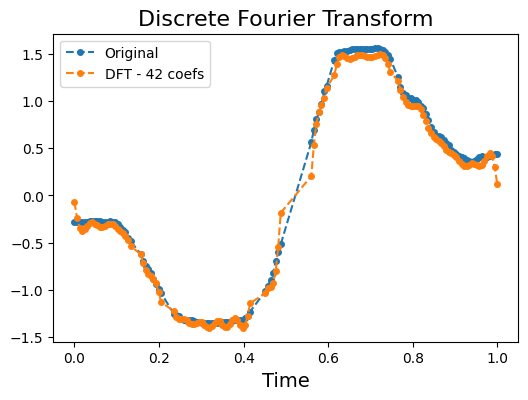

GestureMidAirD3 no. 42, 20.7% processed
LSQ problem


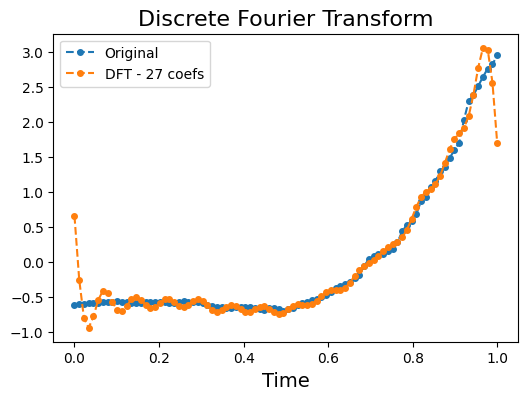

LSQ problem


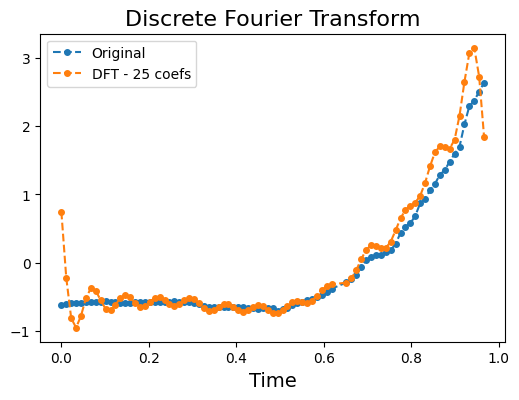

GestureMidAirD3 no. 43, 21.2% processed
LSQ problem


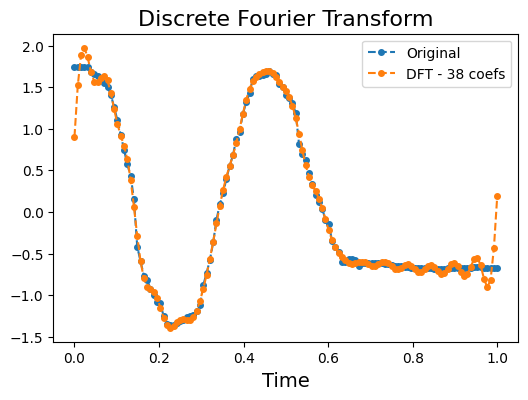

LSQ problem


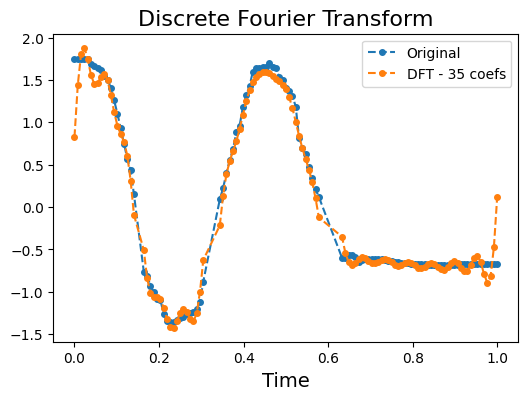

GestureMidAirD3 no. 44, 21.6% processed
LSQ problem


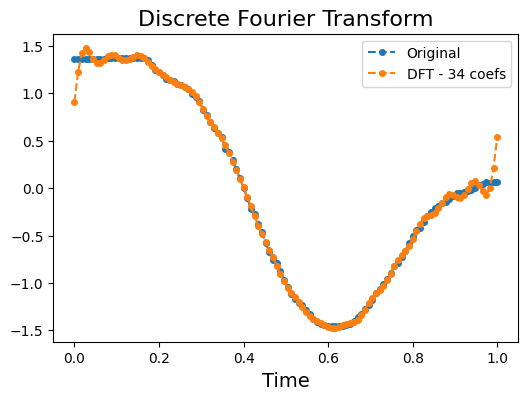

LSQ problem


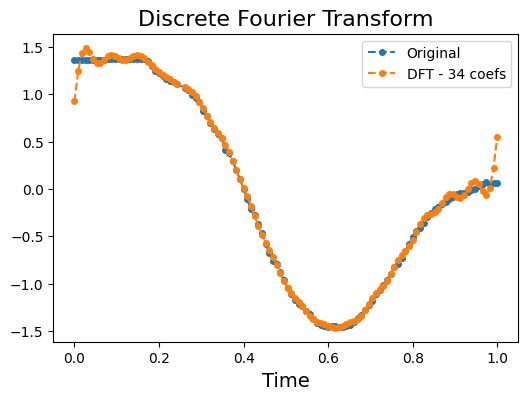

GestureMidAirD3 no. 45, 22.1% processed
LSQ problem


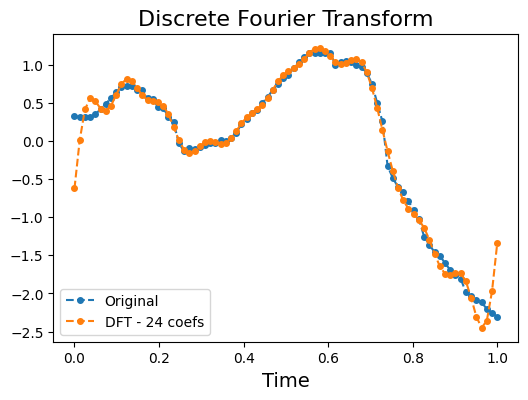

LSQ problem


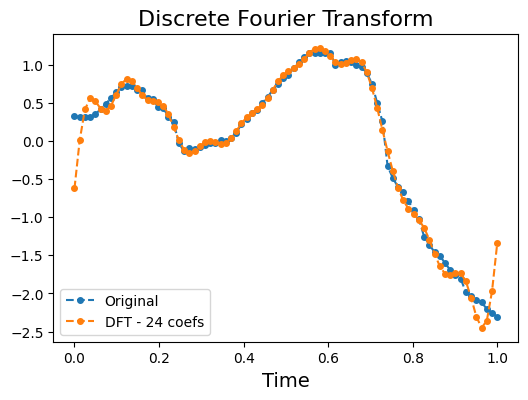

GestureMidAirD3 no. 46, 22.6% processed
LSQ problem


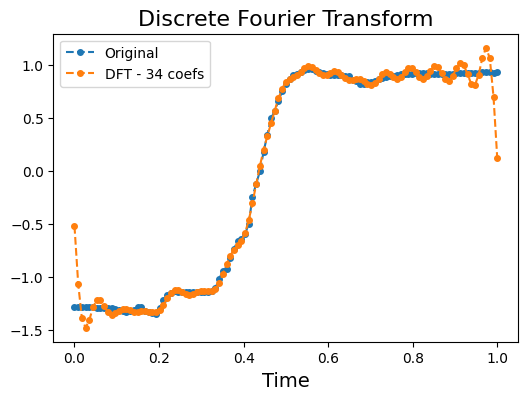

LSQ problem


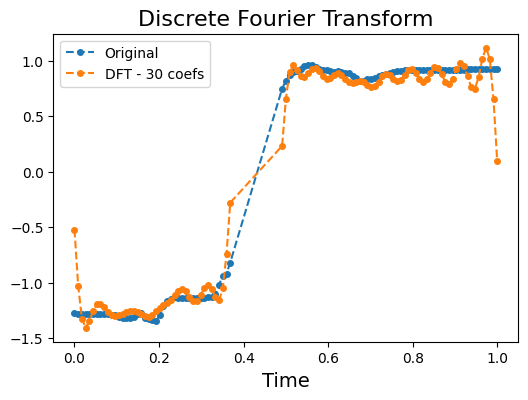

GestureMidAirD3 no. 47, 23.1% processed
LSQ problem


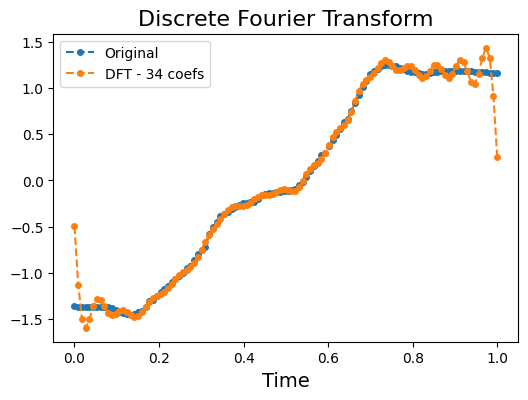

LSQ problem


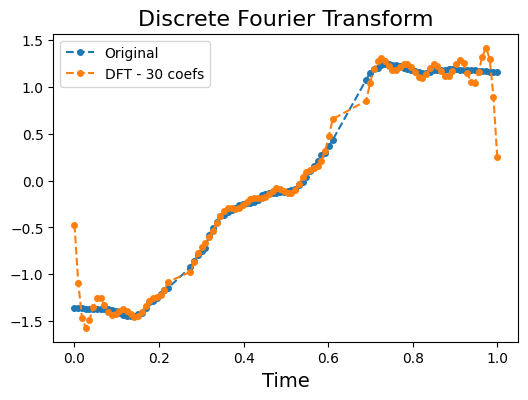

GestureMidAirD3 no. 48, 23.6% processed
LSQ problem


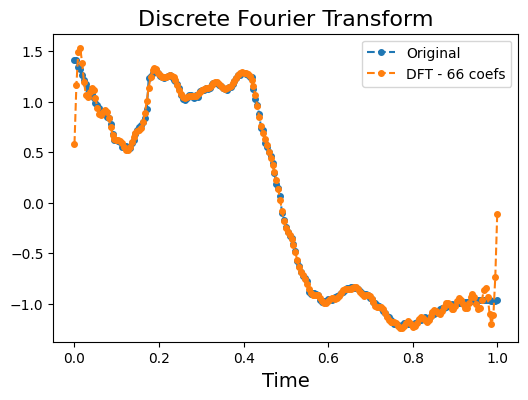

LSQ problem


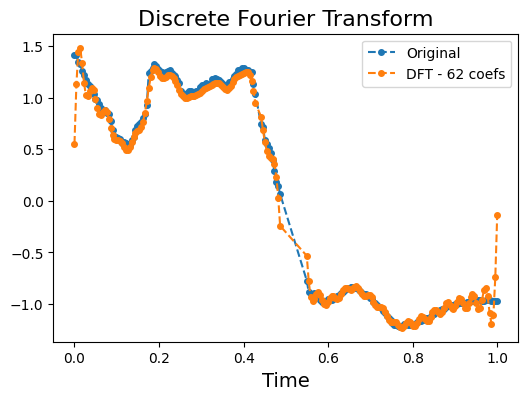

GestureMidAirD3 no. 49, 24.0% processed
LSQ problem


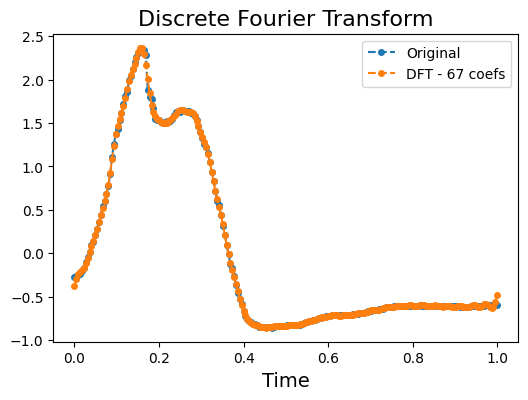

LSQ problem


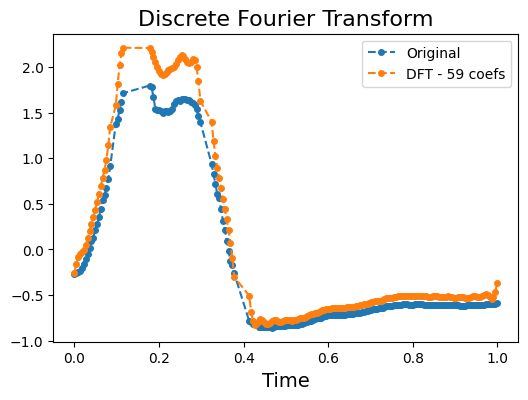

GestureMidAirD3 no. 50, 24.5% processed
LSQ problem


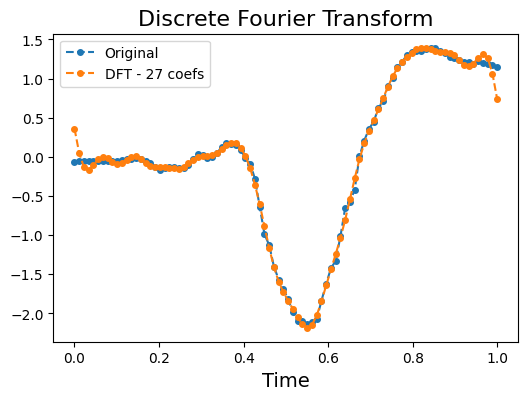

LSQ problem


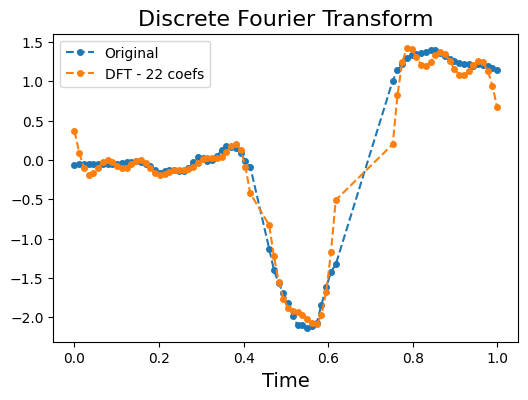

GestureMidAirD3 no. 51, 25.0% processed


In [ ]:
import numpy as np
import scipy.interpolate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plot import plot_inverse_DFT, plot_splines
from utils.data import remove_outliers
from utils.compression import round_to_nearest_ratio
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count, calculate_max_dist
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_PAA, fit_DFT, calculate_inverse_DFT
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

results = []
total_rows = len(data.index)
for idx, (_, row) in enumerate(data.iterrows(), 1):
    ts_with_outliers = row['data']
    ts_without_outliers = remove_outliers(ts_with_outliers)
    ts = [(0, ts_with_outliers), (len(ts_with_outliers) - len(ts_without_outliers), ts_without_outliers)]

    print(f"{row['dataset']} no. {row['num']}, {round(idx / total_rows * 100, 1)}% processed")

    for num_outliers_removed, time_series in ts:
        num_coeffs = generate_coeff_counts(len(time_series), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)
        

        for method, degree in [('L8', 3), ('L8 and L1', 3), ('LSQ', 3), ('PAA', 0), ('PLA', 1)]:
            max_dist = None
            result = None
            
            if method == 'LSQ':
                try:
                    result = scipy.interpolate.make_lsq_spline([x[0] for x in time_series], [x[1] for x in time_series],
                                                               knots, k=degree).c
                    max_dist = calculate_max_dist(knots, result, degree, time_series)
                except Exception as e:
                    #print(f"LSQ problem: {e}")
                    print("LSQ problem")
                    continue
                    
            if method == 'L8 and L1':
                result = fit_max_l1_spline(time_series, knots, degree, eps=0.000001)[1]
                max_dist = calculate_max_dist(knots, result, degree, time_series)[0]
            else:
                max_dist, result = fit_max_spline(time_series, knots, degree)

            if max_dist is not None and result is not None:
                fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
                mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
                mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])
                if method == 'L8 and L1':
                    max_dist = calculate_max_dist(knots, result, degree, time_series)[0]

                results.append({
                    'dataset': row['dataset'],
                    'num': row['num'],
                    'num_data_pts': len(time_series),
                    'num_outliers_removed': num_outliers_removed,
                    'num_coeffs': num_coeffs,
                    'method': method,
                    'max_dist': max_dist,
                    'MSE': mse,
                    'MAE': mae
                })

        # DFT
        result = fit_DFT(time_series, num_coeffs)
        fitted_curve = calculate_inverse_DFT(len(time_series), num_coeffs, result)
        max_dist = np.max(np.abs(fitted_curve - [x[1] for x in time_series]))
        mse = mean_squared_error(fitted_curve, [x[1] for x in time_series])
        mae = mean_absolute_error(fitted_curve, [x[1] for x in time_series])

        plot_inverse_DFT(fitted_curve, time_series,num_coeffs)

        results.append({
            'dataset': row['dataset'],
            'num': row['num'],
            'num_data_pts': len(time_series),
            'num_outliers_removed': num_outliers_removed,
            'num_coeffs': num_coeffs,
            'method': 'DFT',
            'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae
        })
